In [2]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [10]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [41]:
# path = 'data/interrsect_005.nii.gz'
# path = '/home/jbregazzi/Documents/josephine/Datasets/StrokeLesionSegmentation/flair/interrsect/images//home/jbregazzi/Documents/josephine/Datasets/StrokeLesionSegmentation/flair/interrsect/images/INTERRSeCT01-019_FollowUp.nii.gz'
path = '/home/jbregazzi/Documents/josephine/GitHub/Brain-Scan-Example-Data/Interrsect/mini-dataset/INTERRSeCT01-005_FollowUp.nii.gz'


reader = sitk.ImageFileReader()
reader.SetImageIO("NiftiImageIO")
reader.SetFileName(path)
image = reader.Execute()

In [42]:
idxSlice = 24

# int labels to assign to the segmented white and gray matter.
labelWhiteMatter = 1
labelGrayMatter = 2

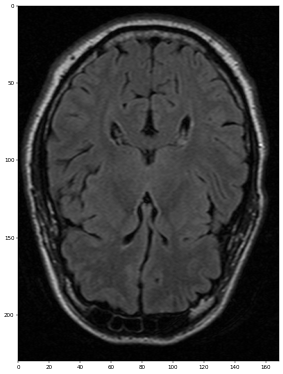

In [43]:
image_1 = image[:,:,idxSlice]

sitk_show(image_1)

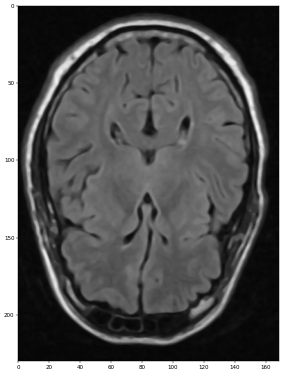

In [44]:
imgSmooth = sitk.CurvatureFlow(image1=image_1,
                                    timeStep=0.125,
                                    numberOfIterations=5)

# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgOriginal)

sitk_show(imgSmooth)

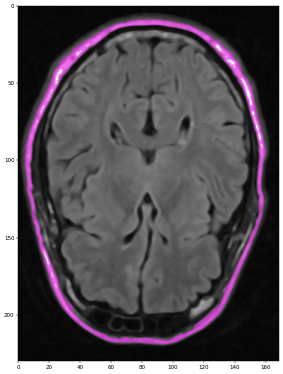

In [66]:
lstSeeds = [(120,44)]
labelSkull = 4

img_skull_hightlighted = sitk.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=300, 
                                              upper=700,
                                              replaceValue=labelSkull)

# Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
imgSkullSmoothInt = sitk.Cast(sitk.RescaleIntensity(imgSmooth), img_skull_hightlighted.GetPixelID())

# Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
sitk_show(sitk.LabelOverlay(imgSkullSmoothInt, img_skull_hightlighted))

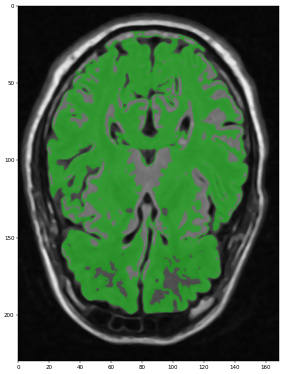

In [95]:
lstSeeds = [(180,70)]

imgWhiteMatter = sitk.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=240, 
                                              upper=330,
                                              replaceValue=labelWhiteMatter)

# Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
imgSmoothInt = sitk.Cast(sitk.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

# Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
sitk_show(sitk.LabelOverlay(imgSmoothInt, imgWhiteMatter))

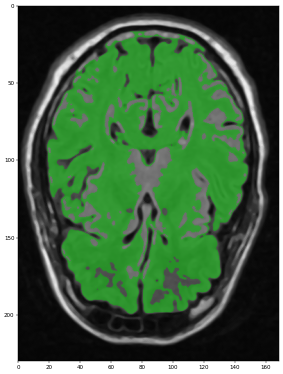

In [96]:
imgWhiteMatterNoHoles = sitk.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                    radius=[2]*3,
                                                    majorityThreshold=1,
                                                    backgroundValue=0,
                                                    foregroundValue=labelWhiteMatter)

sitk_show(sitk.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

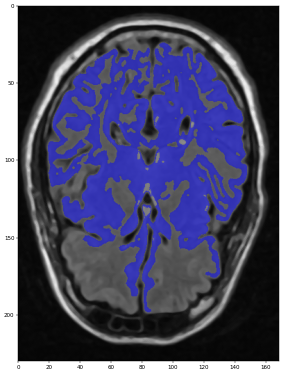

In [97]:
lstSeeds = [(235, 200)] #, (198, 80), (185, 102), (164, 43), (200,200), (180, 190)]

imgGrayMatter = sitk.ConnectedThreshold(image1=imgSmooth, 
                                             seedList=lstSeeds, 
                                             lower=290, 
                                             upper=370,
                                             replaceValue=labelGrayMatter)

imgGrayMatterNoHoles = sitk.VotingBinaryHoleFilling(image1=imgGrayMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=labelGrayMatter)

sitk_show(sitk.LabelOverlay(imgSmoothInt, imgGrayMatterNoHoles))

In [98]:
print(imgGrayMatter.GetSize())

(376, 512)


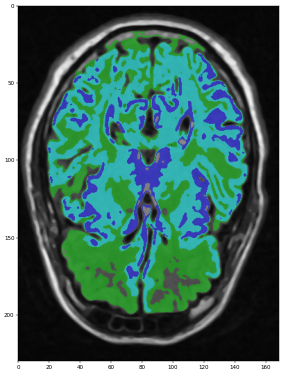

In [99]:
imgLabels = imgWhiteMatterNoHoles | imgGrayMatterNoHoles

sitk_show(sitk.LabelOverlay(imgSmoothInt, imgLabels))